# **Fetal Risk Prediction**


## Importing Libraries 

In [1]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html 

#Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from scipy import stats

#Processing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

#ML models
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


## Loading Data

In [2]:
fetal_df=pd.read_csv('./fetal_health.csv')

## Data Analysis

###Look into the dataset

In [3]:
fetal_df.head(10)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.000,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.000,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.000,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,0.001,0.0,0.010,0.009,0.0,0.002,26.0,5.9,0.0,0.0,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,0.001,0.0,0.013,0.008,0.0,0.003,29.0,6.3,0.0,0.0,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.000,0.0,0.000,0.000,0.0,0.000,83.0,0.5,6.0,15.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.000,0.0,0.002,0.000,0.0,0.000,84.0,0.5,5.0,13.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.000,0.0,0.003,0.000,0.0,0.000,86.0,0.3,6.0,10.6,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


In [4]:
fetal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

The dataset contains 21 features and the target variable 'fetal_health'.

In [5]:
fetal_df.shape

(2126, 22)

In [6]:
# Pre-processing
fetal_df = fetal_df.dropna() # drop the rows where at least one element is missing
fetal_df = fetal_df.drop_duplicates() # remove duplicated rows 
fetal_df.shape

(2113, 22)

13 rows are removed from the dataset.

In [7]:
fetal_df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,133.304780,0.003188,0.009517,0.004387,0.001901,0.000003,0.000159,46.993848,1.335021,9.795078,8.166635,70.535258,93.564600,164.099858,4.077142,0.325603,137.454330,134.599621,138.089446,18.907241,0.318504,1.303833
std,9.837451,0.003871,0.046804,0.002941,0.002966,0.000057,0.000592,17.177782,0.884368,18.337073,5.632912,39.007706,29.562269,17.945175,2.951664,0.707771,16.402026,15.610422,14.478957,29.038766,0.611075,0.614279
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.000000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.005000,0.000000,0.000000,0.000000,49.000000,1.200000,0.000000,7.400000,68.000000,93.000000,162.000000,4.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.000000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.000000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [8]:
fetal_df.fetal_health.value_counts()

1.0    1646
2.0     292
3.0     175
Name: fetal_health, dtype: int64

As we can see many records are normal, and few are belonging to the two other classes. Let's draw a graph that represents the percentage for each type.

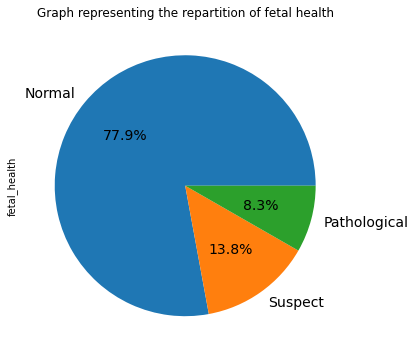

In [9]:
cases_df = fetal_df.copy(deep=True)
cases = pd.DataFrame(cases_df['fetal_health'].replace(1.0,'Normal').replace(2.0,'Suspect').replace(3.0,'Pathological').value_counts())
cases.reset_index(inplace=True)
cases.plot(kind='pie', title='Graph representing the repartition of fetal health',y = 'fetal_health', 
          autopct='%1.1f%%', shadow=False, labels=cases['index'], legend = False, fontsize=14, figsize=(6,6))

The target class, fetal health, is very unbalanced, so we decide to turn this into a binary classification problem to make the data easier to work with. We combine the two classes 2.0 and 3.0 corresponding respectively to Suspect and Pathological fetal health into a class called Distressed.

###Turn problem into a binary classification

In [10]:
# engineering new categorical target column for Normal and Distressed fetal health
fetal_df.loc[fetal_df['fetal_health']==1.000, 'target'] = 0.0 # Normal
fetal_df.loc[fetal_df['fetal_health']==2.000, 'target'] = 1.0 # Distressed
fetal_df.loc[fetal_df['fetal_health']==3.000, 'target'] = 1.0 # Distressed

In [11]:
fetal_df = fetal_df.drop(columns=['fetal_health'], axis=1)

In [12]:
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,target
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0


In [13]:
fetal_df.target.value_counts()

0.0    1646
1.0     467
Name: target, dtype: int64

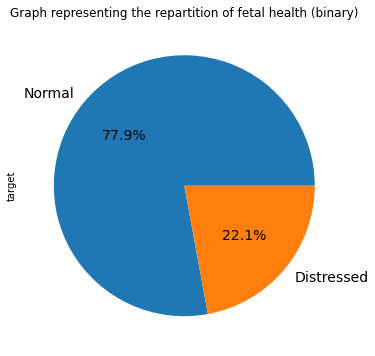

In [14]:
cases_df = fetal_df.copy(deep=True)
cases = pd.DataFrame(cases_df['target'].replace(0.0,'Normal').replace(1.0,'Distressed').value_counts())
cases.reset_index(inplace=True)
cases.plot(kind='pie', title='Graph representing the repartition of fetal health (binary)',y = 'target', 
          autopct='%1.1f%%', shadow=False, labels=cases['index'], legend = False, fontsize=14, figsize=(6,6))

The target class 'target' is still unbalanced but less than previously.

###Preparation train test

In [15]:
#Input and Output
input_df = fetal_df.drop(['target'],axis=1)
output_df = fetal_df['target'].copy() 

In [16]:
# split into train/test sets : 70/30
X_train_no, X_test_no, y_train, y_test = train_test_split(input_df, output_df, test_size=0.3, stratify=output_df, random_state=1) #same proportion of classes 0 and 1 in training and testing

In [17]:
# scaling data to bring all features in the same standing
scalar = StandardScaler() 
scalar.fit(X_train_no)
X_train = scalar.transform(X_train_no)
X_test = scalar.transform(X_test_no)

In [18]:
# Evaluation functions 

def evaluation_training(y_train, y_pred):
    
    # Print Precision, Recall, F1 Score, and Accuracy metrics
    print('Evaluation Metrics for training:')
    print('Precision: %.3f' %precision_score(y_train, y_pred))
    print('Recall: %.3f'%recall_score(y_train, y_pred))
    print('F1 Score: %.3f' %f1_score(y_train, y_pred))
    print('Accuracy: %.3f'%accuracy_score(y_train, y_pred))
    print()

def evaluation_testing(y_test, y_pred):
    
    # Print Precision, Recall, F1 Score, and Accuracy metrics
    print('Evaluation Metrics for testing:')
    print('Precision: %.3f' %precision_score(y_test, y_pred))
    print('Recall: %.3f'%recall_score(y_test, y_pred))
    print('F1 Score: %.3f' %f1_score(y_test, y_pred))
    print('Accuracy: %.3f'%accuracy_score(y_test, y_pred))
    
    # Plot Confusion Matrix
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_test, y_pred).ravel())

    plt.subplots(figsize=(10,8))
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='Blues',annot = True, annot_kws = {'size':15})

## Feature selection

###Correlation matrix with heatmap

In [19]:
# create a dataframe with X_train and y_train concatenated
train_df = pd.DataFrame(X_train, columns=input_df.columns)
train_df['target'] = y_train.to_list()
train_df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,target
0,-1.871485,1.496487,0.883424,0.224803,-0.638058,-0.052076,-0.267678,-1.126387,1.060000,-0.529116,0.712077,1.493861,-1.363640,0.988775,0.987814,-0.452782,-1.154615,-0.959777,-1.271954,-0.167893,-0.534040,0.0
1,-1.264639,2.274997,-0.031147,-1.121283,-0.638058,-0.052076,-0.267678,-0.436872,-0.047005,-0.529116,-0.293378,0.698727,0.286513,1.991524,0.987814,0.908325,-0.293147,-0.251471,-0.439525,-0.370709,-2.179550,0.0
2,-0.556652,-0.839043,0.008617,-0.111719,1.379805,-0.052076,3.130567,-1.413685,1.170701,-0.529116,0.157343,1.391263,-1.363640,0.765942,2.334646,-0.452782,0.322187,-0.895386,-0.508894,2.772932,-0.534040,0.0
3,-0.657793,-0.839043,-0.110675,-1.457804,-0.638058,-0.052076,-0.267678,0.942159,-0.932609,-0.310416,0.521387,0.467882,-1.060551,-0.738182,-0.022311,-0.452782,-0.539281,-0.444645,-0.578263,-0.607327,1.111471,1.0
4,1.466169,0.198970,-0.210085,0.224803,-0.638058,-0.052076,-0.267678,-0.379412,-0.489807,-0.091716,0.608064,-0.609396,1.094751,0.487400,0.314398,-0.452782,1.183655,1.358316,1.364071,-0.539721,-0.534040,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,0.657041,-0.060533,-0.190203,0.897845,0.707184,-0.052076,-0.267678,0.999618,-0.157705,-0.529116,-0.414726,0.083140,0.050777,0.264567,0.651106,-0.452782,0.260654,0.134878,0.254166,-0.032683,-0.534040,0.0
1475,-0.758934,-0.839043,-0.210085,1.907409,-0.638058,-0.052076,-0.267678,-1.471144,0.174396,-0.529116,0.365368,-1.224984,0.690632,-1.518098,-1.032435,-0.452782,-0.539281,-0.444645,-0.578263,-0.607327,-0.534040,0.0
1476,-1.264639,2.015494,-0.210085,-0.448240,-0.638058,-0.052076,-0.267678,-0.781629,0.617198,-0.529116,-0.310713,1.750356,-1.161580,1.880108,2.334646,-0.452782,0.260654,0.134878,0.115428,-0.032683,-0.534040,0.0
1477,1.162746,-0.839043,-0.210085,-0.784761,-0.638058,-0.052076,-0.267678,0.137724,-0.821908,-0.365091,0.573393,-1.122386,1.566223,0.153151,-1.369143,-0.452782,1.306722,1.358316,1.364071,-0.539721,1.111471,1.0


We look to the representation for each feature to have an idea about its distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb332cc0850>,
      dtype=object)

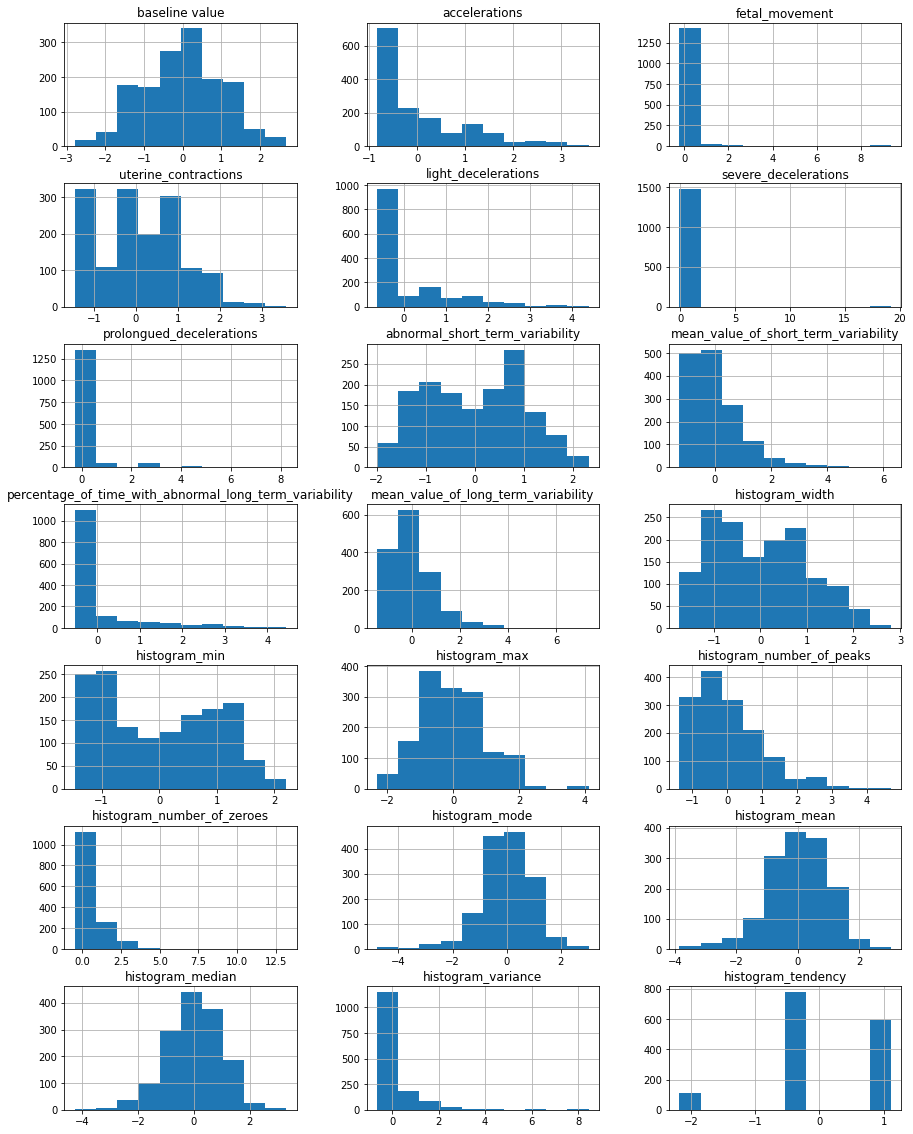

In [20]:
train_df.iloc[:,:-1].hist(figsize=[15,20], layout=[7,3])

To know the influence for each feature on the fetal health we will compare the correlations of all features with target using a heatmap. <br>
Collinearity is the state where two variables are highly correlated and contain similar information about the variance within a given dataset. To detect collinearity among variables, we create a correlation matrix and find variables with large absolute values.

(0.0, 22.0)

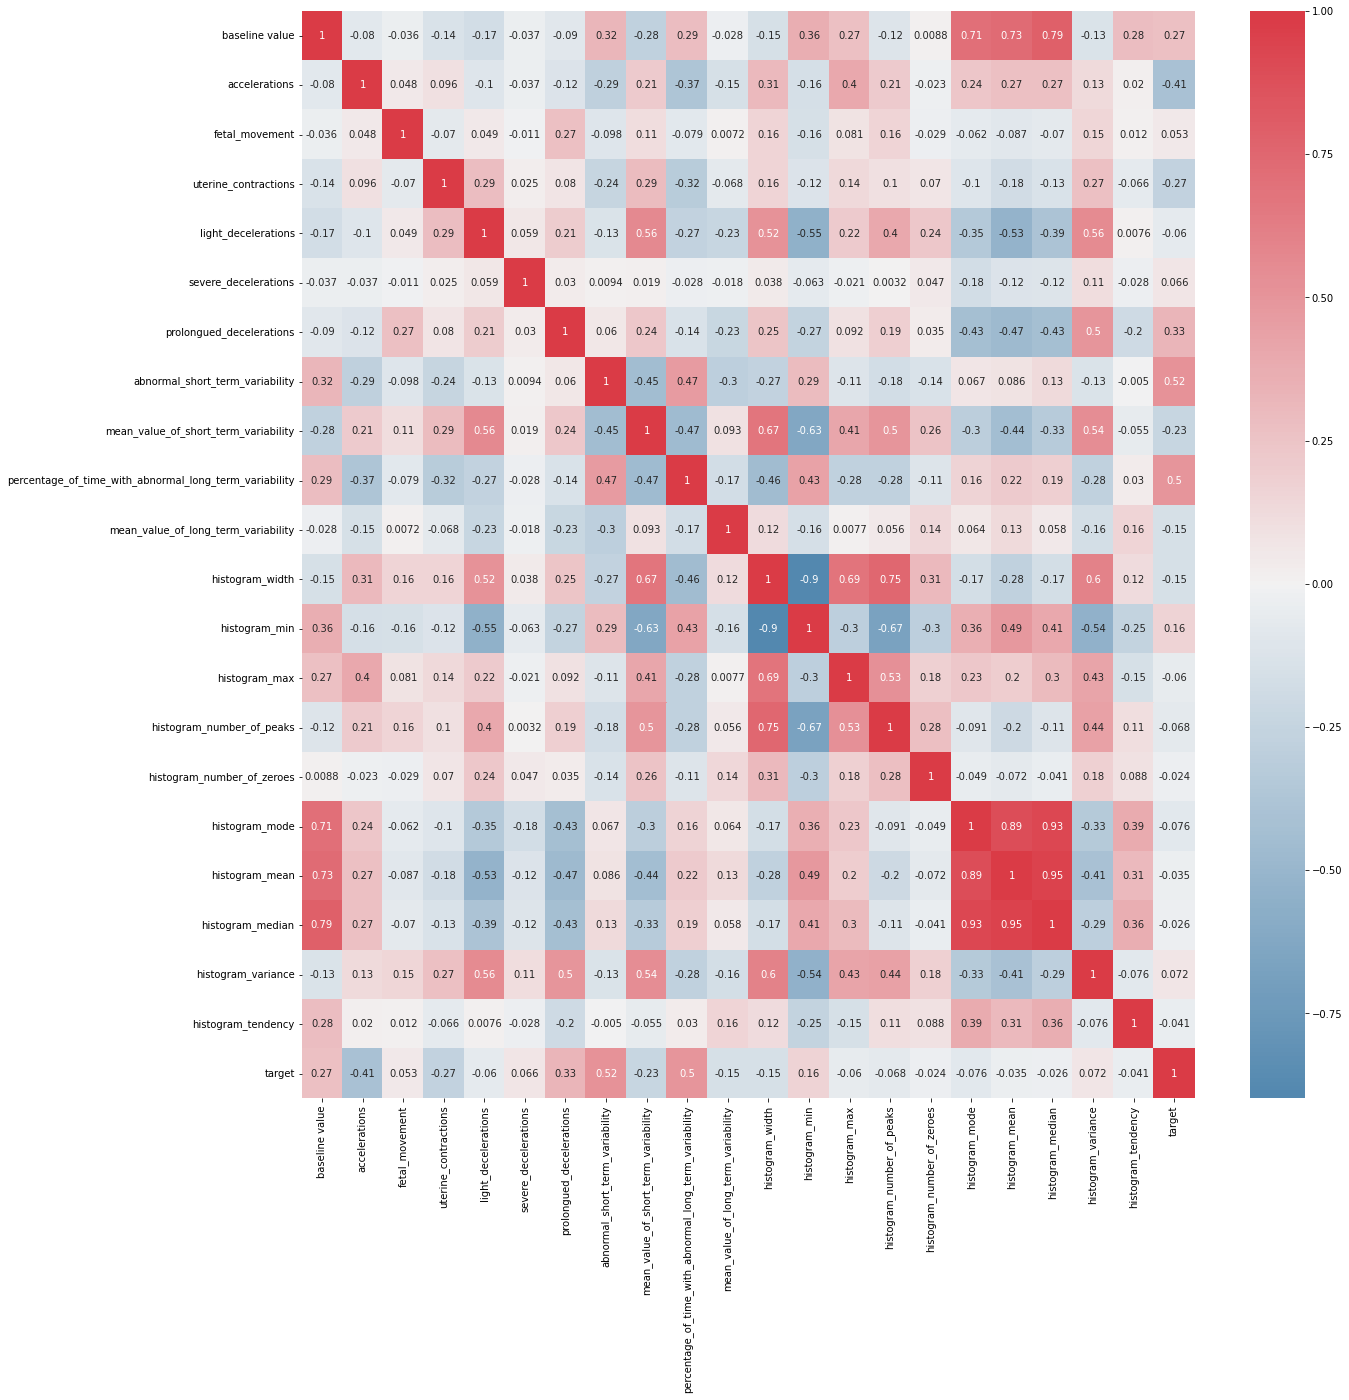

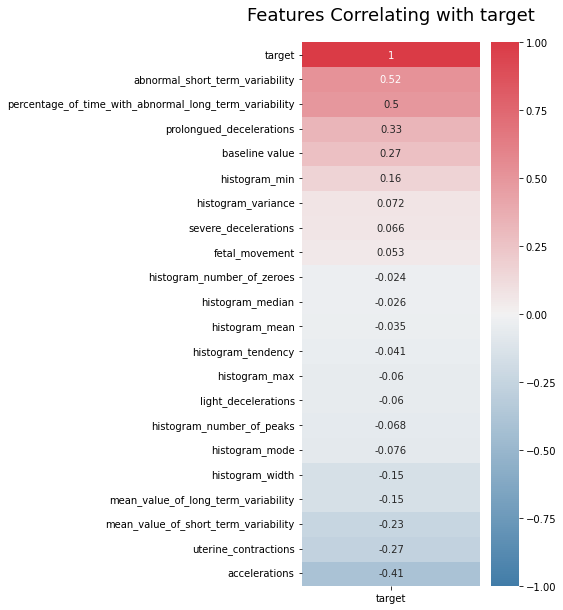

In [21]:
corr = train_df.corr() #correlation matrix

# heatmap showing correlation between all features in pairs
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, center=0.0, vmax=1)

# heatmap showing correlation with target
plt.figure(figsize=(4, 10))
heatmap = sns.heatmap(corr[['target']].sort_values(by='target', ascending=True), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18}, pad=22)
heatmap.set_ylim([0,22])

As we can see, there are many features that have negligible values for correlation with target. To train and test our models we may keep only features with high correlation with fetal health (|correlation| >= 0.15).

Thus, we keep the following 10 best features : abnormal_short_term_variability, percentage_of_time_with_abnormal_long_term_variability, accelerations, prolongued_decelerations, uterine_contractions, baseline value,  mean_value_of_short_term_variability, histogram_min, mean_value_of_long_term_variability, histogram_width.

We can also note that histogram_median, histogram_mode and histogram_mean have high correlations two by two, which means they are dependent. Thus, if we choose one of them, we have to drop the two others as we want to consider only independent features for a model. 

In [22]:
# Create new dataframes with features selection for train and test sets
test_df = pd.DataFrame(X_test, columns=input_df.columns)
X_train_heatmap_fs_df = train_df[['abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'accelerations', 'prolongued_decelerations', 'uterine_contractions',  'baseline value', 'mean_value_of_short_term_variability', 'histogram_min', 'mean_value_of_long_term_variability', 'histogram_width']].copy()
X_test_heatmap_fs_df = test_df[['abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'accelerations', 'prolongued_decelerations', 'uterine_contractions',  'baseline value', 'mean_value_of_short_term_variability', 'histogram_min', 'mean_value_of_long_term_variability', 'histogram_width']].copy()
print(X_train_heatmap_fs_df.shape)
print(X_test_heatmap_fs_df.shape)

(1479, 10)
(634, 10)


Thanks to correlation matrix, we were able to select 10 best features out of 21.

### Filter method: Univariate selection with ANOVA

Now, we implement a filter method of feature selection: ANOVA (analysis of variance). In this method, we compare each feature to the target variable to see if there is any statistically significant relationship between them which gives each feature a score, and we do this comparison ignoring the other features so it is an univariate selection. Then, we select only features with top scores.

                                             Features       Score
7                     abnormal_short_term_variability  535.979823
9   percentage_of_time_with_abnormal_long_term_var...  489.447318
1                                       accelerations  290.810662
6                            prolongued_decelerations  181.459282
3                                uterine_contractions  118.762758
0                                      baseline value  117.032170
8                mean_value_of_short_term_variability   86.324814
12                                      histogram_min   41.248764
10                mean_value_of_long_term_variability   36.347936
11                                    histogram_width   35.422813
16                                     histogram_mode    8.484878
19                                 histogram_variance    7.750158
14                          histogram_number_of_peaks    6.941112
5                                severe_decelerations    6.535168
4         

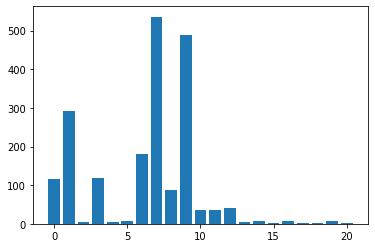

In [23]:
# feature selection with ANOVA
anova_fs = SelectKBest(score_func=f_classif, k=10) # select a subset of features (k=10)
anova_fs.fit(X_train, y_train)	# learn relationship from training data
X_train_anova_fs = anova_fs.transform(X_train) # transform train input data
X_test_anova_fs = anova_fs.transform(X_test) # transform test input data

# scores for the features
dfscores = pd.DataFrame(anova_fs.scores_)
dfcolumns = pd.DataFrame(input_df.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  # naming the dataframe columns
print(featureScores.nlargest(len(anova_fs.scores_),'Score'))  # print features order by scores

# plot the scores
plt.bar([i for i in range(len(anova_fs.scores_))], anova_fs.scores_)
plt.show()

We used SelectKBest with a f_classif scoring metric that evaluates the linear correlation between the features. The graph shows the importance of each feature. We can see that only 10 features have a score >30, others have a score below 10. Thus, we can choose k=10 (keep only 10 best features). 

In [24]:
print("X_train_anova_fs shape", X_train_anova_fs.shape)
print("X_test_anova_fs shape", X_test_anova_fs.shape)

X_train_anova_fs shape (1479, 10)
X_test_anova_fs shape (634, 10)


In [25]:
# List of top 10 most important features
mask = anova_fs.get_support() #list of booleans
new_features = [] # The list of 10 best features
feature_names = list(input_df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print(new_features)

['baseline value', 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min']


In [26]:
# Create new dataframes with features selection for train and test sets
X_train_anova_fs_df = train_df[['baseline value', 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min']].copy()
X_test_anova_fs_df = test_df[['baseline value', 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min']].copy()
print(X_train_anova_fs_df.shape)
print(X_test_anova_fs_df.shape)

(1479, 10)
(634, 10)


By performing features selection through the univariate selection ANOVA, we  selected the same 10 best features out of 21 as with the correlation matrix.

### Wrapper method: Recursive feature elimination with cross-validation (RFECV)

Now, we implement a wrapper method for feature selection: RFECV. A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria to select features. Here we try with Logistic Regression and Random Forest. Features are selected by recursively taking a smaller and smaller subset of features.

####With Logistic Regression

Optimal number of features : 8


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


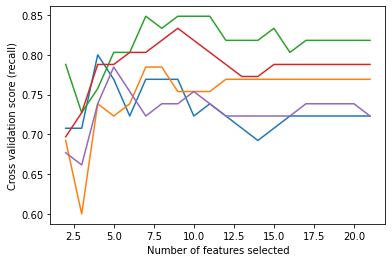

In [27]:
# Create the RFE object and compute a cross-validated score using Logistic Regression
min_features_to_select = 2
rfecv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=StratifiedKFold(5),
    scoring="recall",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [28]:
# List of top 8 most important features
mask = rfecv.support_.tolist() #list of booleans
new_features = [] # The list of 8 best features
feature_names = list(input_df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print(new_features)

['accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'histogram_max', 'histogram_mode', 'histogram_mean', 'histogram_variance']


By performing feature selection with RFECV using Logistic Regression, the optimal number of features found is 8. Among those 8 features, 4 are in the 10 best features obtained with correlation matrix and ANOVA methods: 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability'. <br>
Because 'histogram_mode' and 'histogram_mean' are highly correlated (as we saw with the heatmap), we can drop one of them, let's say 'histogram_mean'. This leaves us with 7 features out of 21. <br>
We notice that 'percentage_of_time_with_abnormal_long_term_variability' is not among the selected features using this method although it was the second most important feature with ANOVA.

In [29]:
# Create new dataframes with features selection for train and test sets
X_train_rfecv_fs_df = train_df[['accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'histogram_max', 'histogram_mode', 'histogram_variance']].copy()
X_test_rfecv_fs_df = test_df[['accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'histogram_max', 'histogram_mode', 'histogram_variance']].copy()
print(X_train_rfecv_fs_df.shape)
print(X_test_rfecv_fs_df.shape)

(1479, 7)
(634, 7)


####With Random Forest

Optimal number of features : 13


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


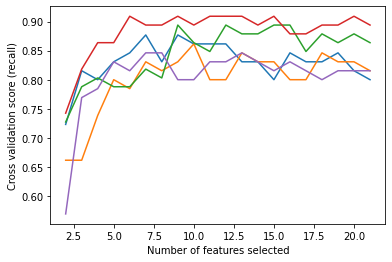

In [30]:
# Create the RFE object and compute a cross-validated score using Random Forest
min_features_to_select = 2
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=1),
    step=1,
    cv=StratifiedKFold(5),
    scoring="recall",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [31]:
# List of top 13 most important features
mask = rfecv.support_.tolist() #list of booleans
new_features = [] # The list of 13 best features
feature_names = list(input_df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print(new_features)

['baseline value', 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_mode', 'histogram_mean', 'histogram_median']


By performing feature selection with RFECV using Random Forest, the optimal number of features found is 13. We obtained the same 10 features as in correlation matrix and ANOVA methods, plus 'histogram_mode', 'histogram_mean', 'histogram_median'. But as these three features are highly correlated, we can choose only 'histogram_mode'. This leaves us with 11 features out of 21. <br>
As there is only one more feature than the selected features with ANOVA, we will refer to the features selection obtained with ANOVA to compare prediction from different models with this features selection method.

###Intrinsic method: Decision tree

Feature selection is naturally incorporated with the modeling process of some machine learning algorithms, for instance decision tree. This is why it is a intrinsic method of feature selection.

Evaluation Metrics for training:
Precision: 0.982
Recall: 0.976
F1 Score: 0.979
Accuracy: 0.991

Evaluation Metrics for testing:
Precision: 0.806
Recall: 0.829
F1 Score: 0.817
Accuracy: 0.918

Confusion Matrix:
 TN,  FP, FN, TP
[466  28  24 116]


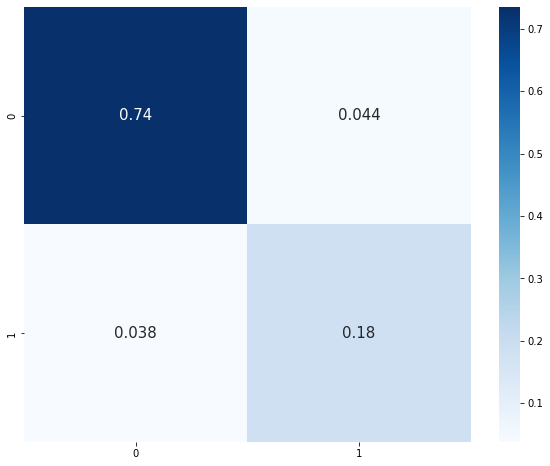

In [32]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train,y_train)

# GridSearch with CV
tuned_parameters = {'max_depth':range(3,20)}
tree_clf = GridSearchCV(tree, tuned_parameters, n_jobs=4, cv=5, scoring='recall')
tree_clf.fit(X_train, y_train)

# Prediction
tree_training = tree_clf.predict(X_train)
tree_testing = tree_clf.predict(X_test)

# Evaluation
evaluation_training(y_train, tree_training)
evaluation_testing(y_test, tree_testing)

In [33]:
print(tree_clf.best_estimator_)
print(tree_clf.best_score_)

DecisionTreeClassifier(max_depth=12, random_state=1)
0.8468065268065269


In [34]:
dfscores = pd.DataFrame(tree.feature_importances_)
dfcolumns = pd.DataFrame(input_df.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                             Features     Score
7                     abnormal_short_term_variability  0.363095
9   percentage_of_time_with_abnormal_long_term_var...  0.156748
6                            prolongued_decelerations  0.111475
17                                     histogram_mean  0.085846
0                                      baseline value  0.052336
8                mean_value_of_short_term_variability  0.043807
12                                      histogram_min  0.036002
1                                       accelerations  0.030442
18                                   histogram_median  0.020018
11                                    histogram_width  0.018730


In [35]:
# List of 10 most important features
featureScores.nlargest(10,'Score')['Features'].tolist()

['abnormal_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'prolongued_decelerations',
 'histogram_mean',
 'baseline value',
 'mean_value_of_short_term_variability',
 'histogram_min',
 'accelerations',
 'histogram_median',
 'histogram_width']

Among those 10 features, 8 are in the 10 best features obtained with correlation matrix and ANOVA methods. However, we notice that 'uterine_contractions' is not among the selected features using this method although it was the fifth most important feature with ANOVA.

In [36]:
# Create new dataframes with features selection for train and test sets
X_train_tree_fs_df = train_df[['abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'prolongued_decelerations', 'histogram_mean', 'baseline value', 'mean_value_of_short_term_variability', 'histogram_min', 'accelerations','histogram_median','histogram_width']].copy()
X_test_tree_fs_df = test_df[['abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'prolongued_decelerations', 'histogram_mean', 'baseline value', 'mean_value_of_short_term_variability', 'histogram_min', 'accelerations','histogram_median','histogram_width']].copy()
print(X_train_tree_fs_df.shape)
print(X_test_tree_fs_df.shape)

(1479, 10)
(634, 10)


#**Prediction with features selection**

The function prediction_performance will generate two tables with all the metrics we need to evaluate our prediction using different models: one table for training and one for testing. At the end, a comparison and analysis of these results will help us to pick the best model for fetal health classification.

In [37]:
def prediction_performance(X_train,y_train, X_test,y_test):

  # classifier names and classes 
  names = ["K Nearest Neighbors", "Logistic Regression", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "MLP","Gradient  Boosting", "Extreme Gradient Boosting"]
  classifiers = [
    KNeighborsClassifier(6),
    LogisticRegression(),
    SVC(kernel="linear", C=10, gamma=0.01),
    SVC(kernel="rbf", C=10, gamma=0.05),
    DecisionTreeClassifier(max_depth=12, random_state=1),
    RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200, random_state=1),
    MLPClassifier(hidden_layer_sizes=(10, 30, 10), alpha= 0.0001, learning_rate='constant',  activation='relu', solver='adam'),
    GradientBoostingClassifier(),
    XGBClassifier()] 
    #Two tables for training and testing results
  model_train = pd.DataFrame(columns=['Model','Training Precision','Training Recall','Training f1 Score', 'Training Accuracy'])
  model_test = pd.DataFrame(columns=['Model','Test Precision','Test Recall','Test f1 Score', 'Test Accuracy'])
    # iterate over classifiers
  for  clf,name in  zip(classifiers,names):
    clf.fit(X_train, y_train)
    train_pred=clf.predict(X_train)
    y_pred = clf.predict(X_test)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1= f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision_tr=precision_score(y_train,train_pred)
    recall_tr=recall_score(y_train,train_pred)
    f1_tr= f1_score(y_train, train_pred)
    accuracy_tr = accuracy_score(y_train,train_pred)

    model_test = model_test.append({'Model': name, 'Test Precision':precision, 'Test Recall':recall, 'Test f1 Score': f1, 'Test Accuracy': accuracy},ignore_index=True )
    model_train = model_train.append({'Model': name, 'Training Precision':precision_tr, 'Training Recall':recall_tr, 'Training f1 Score': f1_tr, 'Training Accuracy': accuracy_tr},ignore_index=True )
 
  m1=model_train.sort_values(ascending=False, by = 'Training Accuracy')
  m2=model_test.sort_values(ascending=False, by = 'Test Accuracy')
  display_html(m1._repr_html_()+m2._repr_html_(),raw=True)

In [38]:
# Prediction without features selection
prediction_performance(X_train,y_train, X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Training Precision,Training Recall,Training f1 Score,Training Accuracy
5,Random Forest,0.996942,0.996942,0.996942,0.998648
7,Gradient Boosting,0.993730,0.969419,0.981424,0.991886
4,Decision Tree,0.981538,0.975535,0.978528,0.990534
8,Extreme Gradient Boosting,0.984127,0.948012,0.965732,0.985125
3,RBF SVM,0.962145,0.932722,0.947205,0.977011
6,MLP,0.956386,0.938838,0.947531,0.977011
0,K Nearest Neighbors,0.937984,0.740061,0.827350,0.931711
1,Logistic Regression,0.826367,0.785933,0.805643,0.916160
2,Linear SVM,0.828479,0.782875,0.805031,0.916160
,Model,Test Precision,Test Recall,Test f1 Score,Test Accuracy


By using all the features (without features selection), we reached an accuracy of 94.6% with random forest model. This model has also the bigger f1 score (87.6%) and precision (90%), and a high recall (86.4%).

Now, we will compare the performance of these models by using the new samples obtained with different features selection methods.

## Correlation matrix with heatmap/ Filter method ANOVA

In [39]:
prediction_performance(X_train_heatmap_fs_df,y_train, X_test_heatmap_fs_df,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Training Precision,Training Recall,Training f1 Score,Training Accuracy
5,Random Forest,0.996933,0.993884,0.995406,0.997972
4,Decision Tree,1.000000,0.963303,0.981308,0.991886
7,Gradient Boosting,0.987138,0.938838,0.962382,0.983773
8,Extreme Gradient Boosting,0.980263,0.911315,0.944532,0.976335
6,MLP,0.905363,0.877676,0.891304,0.952671
3,RBF SVM,0.908197,0.847095,0.876582,0.947262
0,K Nearest Neighbors,0.946565,0.758410,0.842105,0.937120
1,Logistic Regression,0.810897,0.773700,0.791862,0.910074
2,Linear SVM,0.809677,0.767584,0.788069,0.908722
,Model,Test Precision,Test Recall,Test f1 Score,Test Accuracy


We notice that ANOVA algorithm gives approximatively the same results as without any features selection, but it helps a lot to reduce the complexity of this prediction problem by passing from 21 features to only 10. 

## Wrapper method: RFECV with Logistic Regression


In [40]:
prediction_performance(X_train_rfecv_fs_df,y_train, X_test_rfecv_fs_df,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Training Precision,Training Recall,Training f1 Score,Training Accuracy
5,Random Forest,0.993902,0.996942,0.995420,0.997972
4,Decision Tree,0.984802,0.990826,0.987805,0.994591
7,Gradient Boosting,0.962025,0.929664,0.945568,0.976335
8,Extreme Gradient Boosting,0.958333,0.914373,0.935837,0.972279
0,K Nearest Neighbors,0.930464,0.859327,0.893482,0.954699
6,MLP,0.888218,0.899083,0.893617,0.952671
3,RBF SVM,0.875000,0.856269,0.865533,0.941176
2,Linear SVM,0.792453,0.770642,0.781395,0.904665
1,Logistic Regression,0.776398,0.764526,0.770416,0.899256
,Model,Test Precision,Test Recall,Test f1 Score,Test Accuracy


The wrapper method also gives us quite well results for all the metrics, by keeping only 7 features out of 21.

## Intrinsic method: Decision tree

In [41]:
prediction_performance(X_train_tree_fs_df,y_train, X_test_tree_fs_df,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Training Precision,Training Recall,Training f1 Score,Training Accuracy
5,Random Forest,0.996942,0.996942,0.996942,0.998648
4,Decision Tree,0.996875,0.975535,0.986090,0.993915
7,Gradient Boosting,0.963077,0.957187,0.960123,0.982421
8,Extreme Gradient Boosting,0.953125,0.932722,0.942813,0.974983
6,MLP,0.881306,0.908257,0.894578,0.952671
3,RBF SVM,0.909677,0.862385,0.885400,0.950642
0,K Nearest Neighbors,0.921233,0.822630,0.869144,0.945233
2,Linear SVM,0.791411,0.788991,0.790199,0.907370
1,Logistic Regression,0.793651,0.764526,0.778816,0.903989
,Model,Test Precision,Test Recall,Test f1 Score,Test Accuracy


Performing prediction with decision tree as a features selection method is also good, as we can reach high values for the four metrics in both training and testing phases. It gives the best performance among the different methods of features selection, approximately the same results as without features selection, but still not as good as without. 

#**Conclusion**

The features selection did not ameliorates the models mentioned before but we obtained aproximately the same results in both cases (with and without features selection). This is because the dataset used is a public dataset whose features have already been selected and the 11 not selected features still have an influence on the target. However, we were able to find the 10 most important features among the 21, and we get same performance with a minimal number of features. Thus, we reduced the complexity of the problem and we minimized the amount of computations and the time to run our code. <br>
The 10 most important features are those obtained with the intrinsic method which are the following: abnormal_short_term_variability,  percentage_of_time_with_abnormal_long_term_variability, prolongued_decelerations, histogram_mean, baseline value, mean_value_of_short_term_variability, histogram_min, accelerations, histogram_median, histogram_width. <br>
Thus, those features need to be analyzed more carefully by obstetricians. Plus, obstetricians can lean on machine learning algorithms and their experience in order to make a prediction.